In [1]:
import torch.utils
import torch.utils.data
from LSTM.datapreprocessing import create_data

import csv
import os
import pandas as pd
import numpy as np
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F


import torch
import torch.nn as nn

Load in data

In [21]:
##### LOAD IN DATA ####
cwd = os.getcwd()
file1 = cwd + '/data/Coordinates_T30_run_1.csv'
past_timesegments = 5
future_timesegments = 4
batch_size = 15

X_train, y_train = create_data(file1,past_timesegments,future_timesegments)
train_length = 500 # amount of datasets for training
validation_length = 75  # amount of data sets for validation
test_length = 25    # amount of sets used for test set
datalength = 600

for i in range(1,datalength):
    file = cwd + '/data/Coordinates_T30_run_' + str(i+1)+'.csv'
    X_temp, y_temp = create_data(file1,past_timesegments,future_timesegments)

    # train set
    if i < train_length:
        X_train = np.concatenate((X_train,X_temp),axis=0)
        y_train = np.concatenate((y_train,y_temp),axis=0)
    elif i == train_length:
        X_val, y_val = X_temp, y_temp
    elif i > train_length and i < (train_length+validation_length):
        X_val = np.concatenate((X_val,X_temp),axis=0)
        y_val = np.concatenate((y_val,y_temp),axis=0)
    elif i == (train_length+validation_length):
        X_test, y_test = X_temp, y_temp
    else:
        X_test = np.concatenate((X_test,X_temp),axis=0)
        y_test = np.concatenate((y_test,y_temp),axis=0)

# make dataloader from numpy arrays
## Trainloader
X_tensor, y_tensor = torch.from_numpy(X_train), torch.from_numpy(y_train)
X_tensor, y_tensor = X_tensor.type(torch.FloatTensor), y_tensor.type(torch.FloatTensor)
dataset = torch.utils.data.TensorDataset(X_tensor,y_tensor)
train_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size,shuffle=False)

## Validation loader
X_tensor, y_tensor = torch.from_numpy(X_val), torch.from_numpy(y_val)
X_tensor, y_tensor = X_tensor.type(torch.FloatTensor), y_tensor.type(torch.FloatTensor)
dataset = torch.utils.data.TensorDataset(X_tensor,y_tensor)
val_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size,shuffle=False)


## Test loader
X_tensor, y_tensor = torch.from_numpy(X_test), torch.from_numpy(y_test)
X_tensor, y_tensor = X_tensor.type(torch.FloatTensor), y_tensor.type(torch.FloatTensor)
dataset = torch.utils.data.TensorDataset(X_tensor,y_tensor)
test_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1,shuffle=False)

33000
4950
1650


Initiate model (LSTM)

In [3]:
# Define the LSTM model
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, future_timesegments):
        super(SimpleLSTM, self).__init__()
        self.future_timesegments = future_timesegments
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.LSTM_cell = nn.LSTM(input_size, hidden_size,  num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        # self.fc2 = nn.Linear(hidden_size, 50)
        self.fc3 = nn.Linear(hidden_size,output_size)


    def forward(self, x, hidden):
        # Forward pass through the RNN layer
        out, hidden = self.LSTM_cell(x, hidden)
        # Reshape the output to fit into the fully connected layer
        # out = out.contiguous().view(-1, self.hidden_size) many to one
        out = out[:, -future_timesegments:, :] # --> Last time step 
        # out = F.relu(self.fc1(out))
        out = F.relu(self.fc1(out))
        # out = F.sigmoid(self.fc2(out))
        out = self.fc3(out)
        # print(out.shape)
        return out, hidden

    def init_hidden(self, x):
        # Initialize hidden state with zeros
        return (torch.zeros(self.num_layers, x.size(0), self.hidden_size),torch.zeros(self.num_layers, x.size(0), self.hidden_size))

# Define input, hidden, and output sizes
input_size = 2  # Size of input vectors (x and y coordinates)
hidden_size = 500  # Size of hidden state (hyperparameter)
output_size = 2  # Size of output vectors (x and y coordinates)
num_layers = 2 # amount of layers (hyperparameter)

# Create an instance of the LSTM model
LSTM_model = SimpleLSTM(input_size, hidden_size, output_size, num_layers, future_timesegments)

Train model (LSTM)

In [4]:
Training = False
criterion = nn.MSELoss()
if Training == True:


    learning_rate = 0.005
    num_epochs = 15
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=learning_rate)  

    # Train the model
    n_total_steps = len(train_loader)
    val_losses_lstm = []
    train_losses_lstm = []
    for epoch in range(num_epochs):
        epoch_loss_val = 0
        epoch_loss_train = 0
        for i, (past, future) in enumerate(train_loader):  
        
            hidden = LSTM_model.init_hidden(past)
            future_pred, _ = LSTM_model(past,hidden)
            loss = criterion(future_pred, future)
            epoch_loss_train += loss.item()
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        for i, (past, future) in enumerate(val_loader):  
            hidden = LSTM_model.init_hidden(past)

            future_pred, _ = LSTM_model(past,hidden)
            loss = criterion(future_pred, future)
            epoch_loss_val += loss.item()
        train_losses_lstm.append(epoch_loss_train/len(train_loader))
        val_losses_lstm.append(epoch_loss_val/len(val_loader))
        print('epoch: {epoch}: train_loss: {epoch_loss_train}, val_loss: {epoch_loss_val}'.format(epoch=epoch+1,epoch_loss_train=epoch_loss_train/len(train_loader),epoch_loss_val=epoch_loss_val/len(val_loader)))

    # model_scripted = torch.jit.script(rnn_model) # Export to TorchScript
    torch.save(LSTM_model,'FINAL_MODELS/LSTM_PAST5_FUTURE4_H500_L2RELU_V2.pt') # Save

epoch: 1: train_loss: 7.929671390966766, val_loss: 2.9107609929686244
epoch: 2: train_loss: 4.700886952415616, val_loss: 1.5499395418234847
epoch: 3: train_loss: 2.4503305599427865, val_loss: 1.40912335653874
epoch: 4: train_loss: 1.6910977102088773, val_loss: 1.6330606233836575
epoch: 5: train_loss: 1.5841049819994606, val_loss: 1.4977376159619202
epoch: 6: train_loss: 1.7565246471961753, val_loss: 1.4121610105185853
epoch: 7: train_loss: 1.4514187422758154, val_loss: 1.3904845757636146
epoch: 8: train_loss: 1.4576075622518494, val_loss: 1.3961155344308778
epoch: 9: train_loss: 1.5272052967054035, val_loss: 1.3897984466913675
epoch: 10: train_loss: 1.440484142521633, val_loss: 2.6339573007584973
epoch: 11: train_loss: 1.5071550892404246, val_loss: 1.3896435759842545
epoch: 12: train_loss: 1.415857716617419, val_loss: 1.3937848525714467
epoch: 13: train_loss: 1.4520639076437551, val_loss: 1.3901072717906737
epoch: 14: train_loss: 1.4191388360935129, val_loss: 1.3895308342216595
epoch: 

Test performance on test set (LSTM)

In [19]:
LSTM_model = torch.load('FINAL_MODELS/LSTM_PAST5_FUTURE4_H500_L2RELU_V2.pt') # Save

with torch.no_grad():
    losses = np.zeros(len(test_loader))
    for i, (past, future) in enumerate(test_loader):  
            hidden = LSTM_model.init_hidden(past)
            future_pred, _ = LSTM_model(past,hidden)
            loss = criterion(future_pred, future)
            losses[i] = loss.item()
test_loss = np.mean(losses)
test_loss_std = np.std(losses)
print("Test Loss (MSE): ", test_loss)
print("Test std error: ", test_loss_std)
print("Max error: ", np.max(losses))

Test Loss (MSE):  1.4116205881646513
Test std error:  3.7756845060088224
Max error:  15.777353286743164


Plot some trajectories (LSTM)

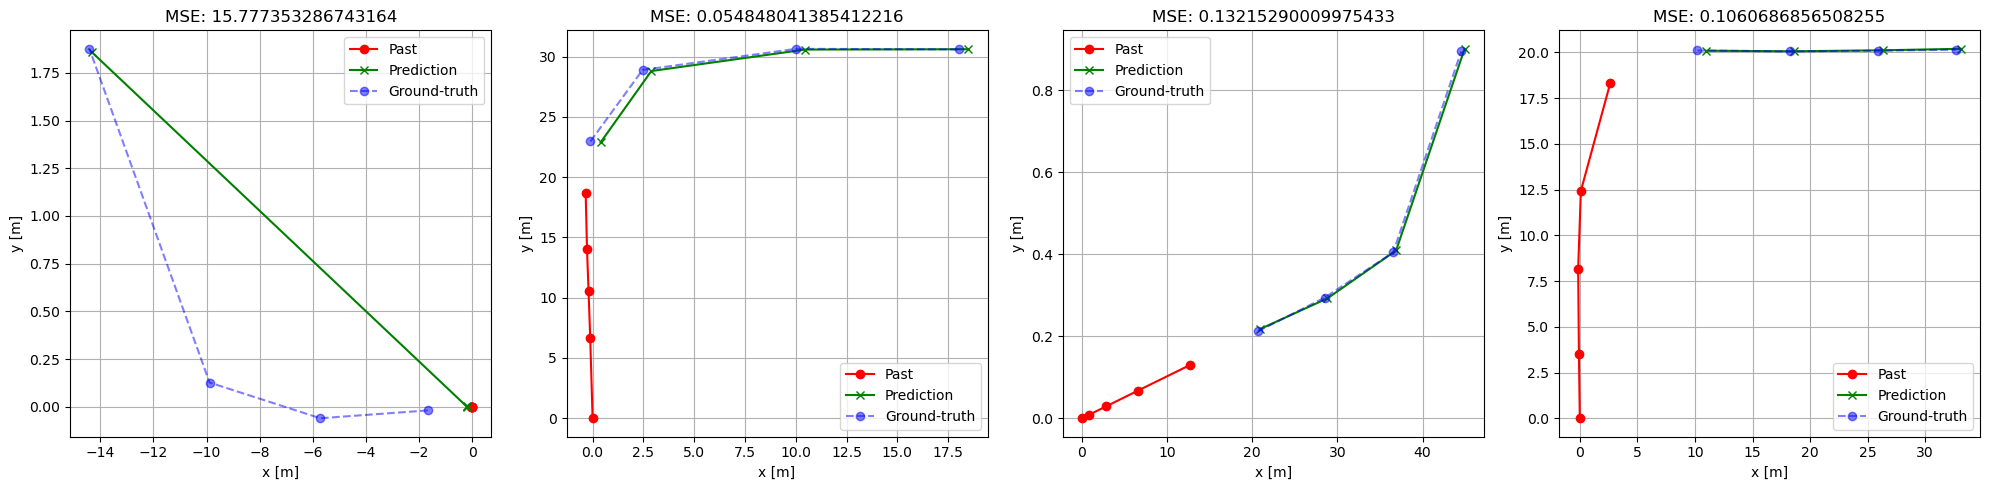

In [20]:
import matplotlib.pyplot as plt
pred = np.zeros((4,4,2))
ground_truth = np.zeros((4,4,2))
past_np = np.zeros((4,5,2))
j = 0
# sorted_indices = np.argsort(losses)

# The second largest value will be at the second to last index in the sorted array
# second_largest_index = sorted_indices[-10]
samples = [np.argmax(losses), 351, 599, 201]
with torch.no_grad():
    test_loss = 0
    for i, (past, future) in enumerate(test_loader):  
            hidden = LSTM_model.init_hidden(past)
            future_pred, _ = LSTM_model(past,hidden)
            if i in samples:
                pred[j] = future_pred.detach().numpy()
                ground_truth[j] = future.detach().numpy()
                past_np[j] = past.detach().numpy()
                j += 1
#             loss = criterion(future_pred, future)
#             test_loss += loss.item()
# test_loss = test_loss / len(test_loader)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot different data on each subplot
for i, ax in enumerate(axes):
    ax.plot(past_np[i,:,0], past_np[i,:,1], linestyle='-', color='r', label='Past', marker='o')
    ax.plot(pred[i,:,0], pred[i,:,1], linestyle='-', color='g', label='Prediction', marker='x')
    ax.plot(ground_truth[i,:,0], ground_truth[i,:,1], linestyle='--', color='b', label='Ground-truth', marker='o',alpha=0.5)
    ax.set_title('MSE: {loss}'.format(loss=losses[samples[i]]))
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.legend()
    ax.grid(True)  # Adding grid

# Adjust layout and display the plot
plt.tight_layout()
plt.show()



In [14]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, future_timesegments):
        super(SimpleRNN, self).__init__()
        self.future_timesegments = future_timesegments
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.LSTM_cell = nn.RNN(input_size, hidden_size,  num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        # self.fc2 = nn.Linear(hidden_size, 50)
        self.fc3 = nn.Linear(hidden_size,output_size)


    def forward(self, x, hidden):
        # Forward pass through the RNN layer
        out, hidden = self.LSTM_cell(x, hidden)
        # Reshape the output to fit into the fully connected layer
        # out = out.contiguous().view(-1, self.hidden_size) many to one
        out = out[:, -4:, :] # --> Last time step 
        # out = F.relu(self.fc1(out))
        out = F.relu(self.fc1(out))
        # out = F.sigmoid(self.fc2(out))
        out = self.fc3(out)
        # print(out.shape)
        return out, hidden

    def init_hidden(self, x):
        # Initialize hidden state with zeros
        return torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    
input_size = 2  # Size of input vectors (x and y coordinates)
hidden_size = 175  # Size of hidden state (hyperparameter)
output_size = 2  # Size of output vectors (x and y coordinates)
num_layers = 1# amount of layers (hyperparameter)


# Create an instance of the LSTM model
RNN_model = SimpleRNN(input_size, hidden_size, output_size, num_layers, future_timesegments)

Train RNN model

In [15]:
Training = False
criterion = nn.MSELoss()
epoch = 0
if Training == True:

    learning_rate = 0.005
    num_epochs = 15
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(RNN_model.parameters(), lr=learning_rate)  

    # Train the model
    n_total_steps = len(train_loader)
    val_losses_rnn = []
    train_losses_rnn = []
    for epoch in range(num_epochs):
        epoch_loss_val = 0
        epoch_loss_train = 0
        for i, (past, future) in enumerate(train_loader):  
        
            hidden = RNN_model.init_hidden(past)
            future_pred, _ = RNN_model(past,hidden)
            loss = criterion(future_pred, future)
            epoch_loss_train += loss.item()
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        for i, (past, future) in enumerate(val_loader):  
            hidden = RNN_model.init_hidden(past)

            future_pred, _ = RNN_model(past,hidden)
            loss = criterion(future_pred, future)
            epoch_loss_val += loss.item()
        train_losses_rnn.append(epoch_loss_train/len(train_loader))
        val_losses_rnn.append(epoch_loss_val/len(val_loader))
        print('epoch: {epoch}: train_loss: {epoch_loss_train}, val_loss: {epoch_loss_val}'.format(epoch=epoch+1,epoch_loss_train=epoch_loss_train/len(train_loader),epoch_loss_val=epoch_loss_val/len(val_loader)))
        epoch = epoch + 1
        if epoch_loss_val/len(val_loader) < 1.8:
            break
    # model_scripted = torch.jit.script(rnn_model) # Export to TorchScript
    torch.save(RNN_model,'FINAL_MODELS/RNN_PAST5_FUTURE4_H500_L2RELU_V2.pt') # Save

epoch: 1: train_loss: 10.300321487540549, val_loss: 5.581438941034404
epoch: 2: train_loss: 6.092297208229588, val_loss: 5.618984202092344
epoch: 3: train_loss: 5.335890763628889, val_loss: 4.315776237709955
epoch: 4: train_loss: 4.6153406118567695, val_loss: 3.4810734391212463
epoch: 5: train_loss: 4.5323200304569164, val_loss: 13.956465672362935
epoch: 6: train_loss: 3.728813249584795, val_loss: 2.6194950724867256
epoch: 7: train_loss: 2.89789320634932, val_loss: 2.427919216284698
epoch: 8: train_loss: 2.7291801419706, val_loss: 2.2744530629027975
epoch: 9: train_loss: 2.4314407383913004, val_loss: 3.1133416572755035
epoch: 10: train_loss: 2.6531192681481217, val_loss: 1.948566417802464
epoch: 11: train_loss: 2.3247887716268782, val_loss: 1.7832273352383212


Test performance on test set (RNN)

In [16]:
RNN_model = torch.load('FINAL_MODELS/RNN_PAST5_FUTURE4_H500_L2RELU_V2.pt') # Save

with torch.no_grad():
    losses = np.zeros(len(test_loader))
    for i, (past, future) in enumerate(test_loader):  
            hidden = RNN_model.init_hidden(past)
            future_pred, _ = RNN_model(past,hidden)
            loss = criterion(future_pred, future)
            losses[i] = loss.item()
test_loss = np.mean(losses)
test_loss_std = np.std(losses)
print("Test Loss (MSE): ", test_loss)
print("Test std error: ", test_loss_std)
print("Max error: ", np.max(losses))

Test Loss (MSE):  1.783227293145363
Test std error:  4.462137389718835
Max error:  16.212650299072266


Text(0, 0.5, 'MSE Loss')

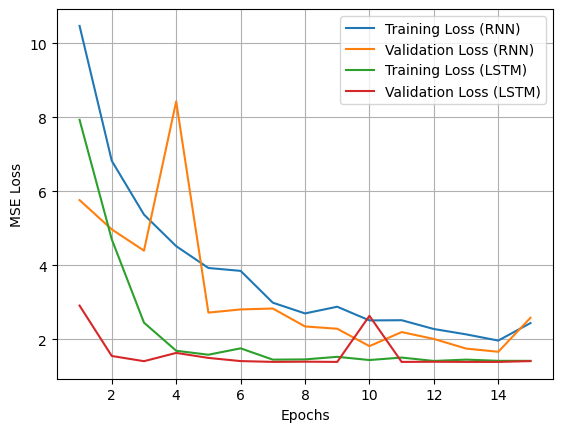

In [12]:
import matplotlib.pyplot as plt
x = np.arange(1,len(train_losses_rnn)+1)
plt.plot(x,train_losses_rnn, label = 'Training Loss (RNN)')
plt.plot(x,val_losses_rnn, label = 'Validation Loss (RNN)')



x = np.arange(1,len(train_losses_lstm)+1)
plt.plot(x,train_losses_lstm, label = 'Training Loss (LSTM)')
plt.plot(x,val_losses_lstm, label = 'Validation Loss (LSTM)')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')